# denoising mnist

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import copy
import sys
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

C:\Users\ayxan\AppData\Local\Temp\ipykernel_21836\3664698699.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )
print(device)

cuda:0


# data

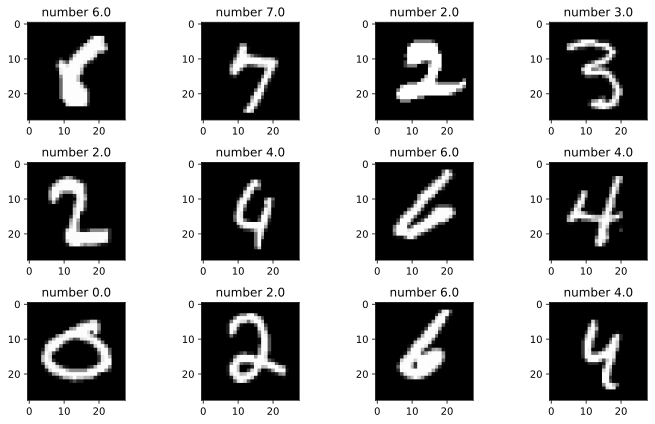

In [4]:
data=np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')
label=data[:,0]
data=data[:,1:]

fig,axs=plt.subplots(3,4,figsize=(10,6))
for ax in axs.flatten():
    randimg=np.random.randint(0,data.shape[0])
    img=np.reshape(data[randimg,:],(28,28))
    ax.imshow(img,cmap='gray')
    
    ax.set_title(f"number {label[randimg]}")
    
plt.tight_layout()
plt.show()

In [14]:
dataNorm=data/np.max(data)

dataT=torch.tensor(dataNorm).float()

train_loader=DataLoader(dataT[:18000,:],batch_size=32,shuffle=True,drop_last=True)
test_loader=DataLoader(dataT[18000:20000,:],batch_size=1000)

# neural network

In [6]:
def createModel(encod,lat):
    class model(nn.Module):
        def __init__(self,encod,lat):
            super().__init__()
            
            self.input=nn.Linear(784,encod)
            
            self.encoder=nn.Linear(encod,lat)
            
            self.latent=nn.Linear(lat,encod)
            
            self.decoder=nn.Linear(encod,784)
            
        def forward(self,x):
            
            x=F.relu( self.input(x) )
            
            x=F.relu(self.encoder(x))
            x=F.relu(self.latent(x))
            
            x=torch.sigmoid(self.decoder(x))
            return x
    
    ann=model(encod,lat)
    
    lossfun=nn.MSELoss()
    
    optimizer=torch.optim.Adam(ann.parameters(),lr=0.001)
    
    return ann,lossfun,optimizer

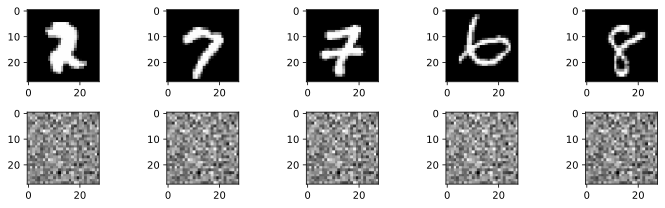

In [7]:
Ann=createModel(150,20)[0]
test=dataT[10:15,:]
yHat=Ann(test)

fig,ax=plt.subplots(2,5,figsize=(10,3))
for i in range(5):
    ax[0,i].imshow(test[i,:].view(28,28).detach(),cmap='gray')
    ax[1,i].imshow(yHat[i,:].view(28,28).detach(),cmap='gray')
    
plt.tight_layout()
plt.show()

# model train

In [8]:
def trainModel(encod,lat,numepoch=10):
    ANN,lossfun,optimizer=createModel(encod,lat)
    
    losses=torch.zeros(numepoch)
    ANN.to(device)
    
    for epoch in range(numepoch):
        batch_loss=[]
        for dat in train_loader:
            
            dat=dat.to(device)

            yHat=ANN(dat)
            loss=lossfun(yHat,dat)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
        losses[epoch]=np.mean(batch_loss)
    return ANN,losses

# model training over differente models

In [9]:
encoder_units=np.linspace(100,500,12).astype(int)
bottleNeck_units=np.linspace(5,100,8).astype(int)

resultsLoss=np.zeros((len(encoder_units),len(bottleNeck_units)))

theBestAnn={'loss':0.0,'module':None,'encod':0.0,'bottle':0.0}

for en,Nenc in enumerate(encoder_units):
    for la,Nlat in enumerate(bottleNeck_units):
        ann,losses=trainModel(Nenc,Nlat,10)
        
        resultsLoss[en,la]=losses[-1]
        
        if theBestAnn['loss']<losses[-1]:
            theBestAnn['loss']=losses[-1]
            theBestAnn['module']=copy.deepcopy(ann.state_dict())
            theBestAnn['encod']=Nenc
            theBestAnn['bottle']=Nlat
            
        totalIter=len(encoder_units)*len(bottleNeck_units)
        currentIter=en*len(bottleNeck_units)+la+1
        msg='Finished process step {}/{}'.format(currentIter,totalIter)
        sys.stdout.write('\r'+msg)

Finished process step 96/96

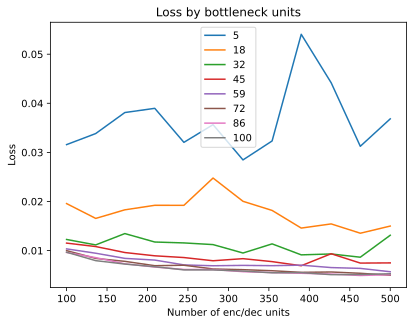

In [10]:
plt.plot(encoder_units,resultsLoss)
plt.legend(bottleNeck_units)
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')
plt.show()

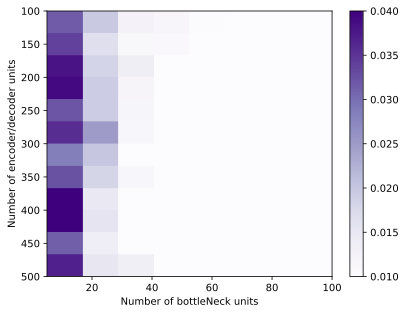

In [11]:
plt.imshow(resultsLoss,aspect='auto',vmin=.01,vmax=.04,cmap='Purples',\
          extent=[bottleNeck_units[0],bottleNeck_units[-1],encoder_units[-1],encoder_units[0]])

plt.xlabel('Number of bottleNeck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()
plt.show()

# model testing over the best model

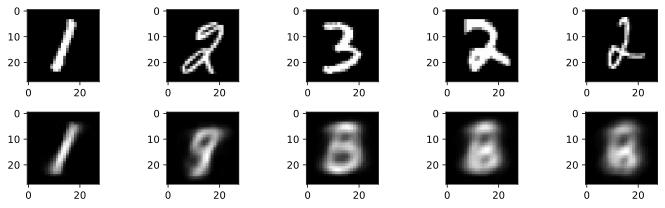

In [15]:
testdata=test_loader.dataset[20:25,:]
testdata=testdata.to(device)

encod=theBestAnn['encod']
bottle=theBestAnn['bottle']
bestANN=createModel(encod,bottle)[0]
bestANN.load_state_dict(theBestAnn['module'])

bestANN=bestANN.to(device)
result=bestANN(testdata)

result=result.cpu()
testdata=testdata.cpu()

fig,ax=plt.subplots(2,5,figsize=(10,3))

for i in range(5):
    ax[0,i].imshow(testdata[i,:].view(28,28).detach(),cmap='gray')
    ax[1,i].imshow(result[i,:].view(28,28).detach(),cmap='gray')
    
plt.tight_layout()
plt.show()

# network testing over noised images

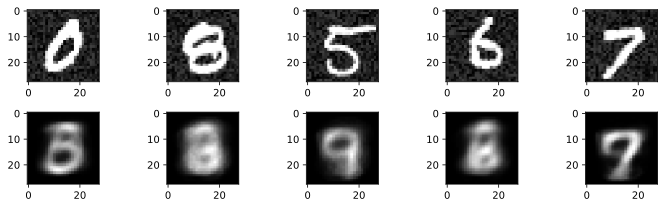

In [16]:
randomidx=np.random.randint(test_loader.dataset.shape[0],size=5)
Img_thatnoise=test_loader.dataset[randomidx,:]
noiseImg=Img_thatnoise+torch.rand_like(Img_thatnoise)/4
noiseImg[noiseImg>1]=1

noiseImg=noiseImg.to(device)

encod=theBestAnn['encod']
bottle=theBestAnn['bottle']
bestANN=createModel(encod,bottle)[0]
bestANN.load_state_dict(theBestAnn['module'])

bestANN=bestANN.to(device)
modelRes=bestANN(noiseImg)

noiseImg=noiseImg.cpu()
modelRes=modelRes.cpu()

fig,ax=plt.subplots(2,5,figsize=(10,3))

for i in range(5):
    ax[0,i].imshow(noiseImg[i,:].view(28,28).detach(),cmap='gray')
    ax[1,i].imshow(modelRes[i,:].view(28,28).detach(),cmap='gray')
    
plt.tight_layout()
plt.show()